In [121]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel

# input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))
hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')
guidance_scale = 7.5

""" Change the text in the original image by coordinates and  """

sample_text="MLVU Project"
prompt = "a dog"



# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 
arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


img = out
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
gray = img
_, binary_tss = cv2.threshold(
    gray, 50, 255, cv2.THRESH_BINARY
)

_, binary_bbox = cv2.threshold(
    gray, 200, 255, cv2.THRESH_BINARY
)

binary_tss_pil = Image.fromarray(binary_tss, 'L')
binary_bbox_pil = Image.fromarray(binary_bbox, 'L')



Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

Mask shape:  (512, 512)


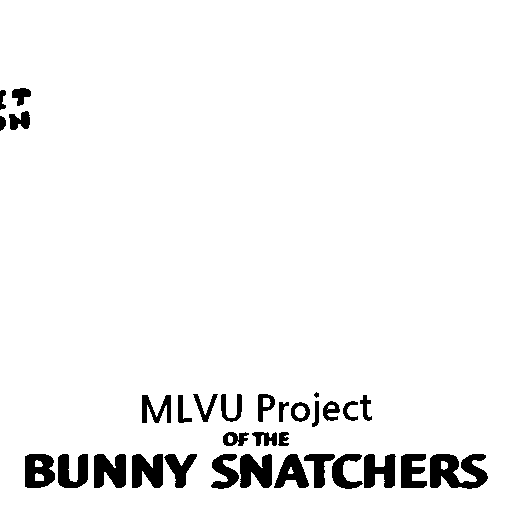

In [122]:
display(binary_tss_pil)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

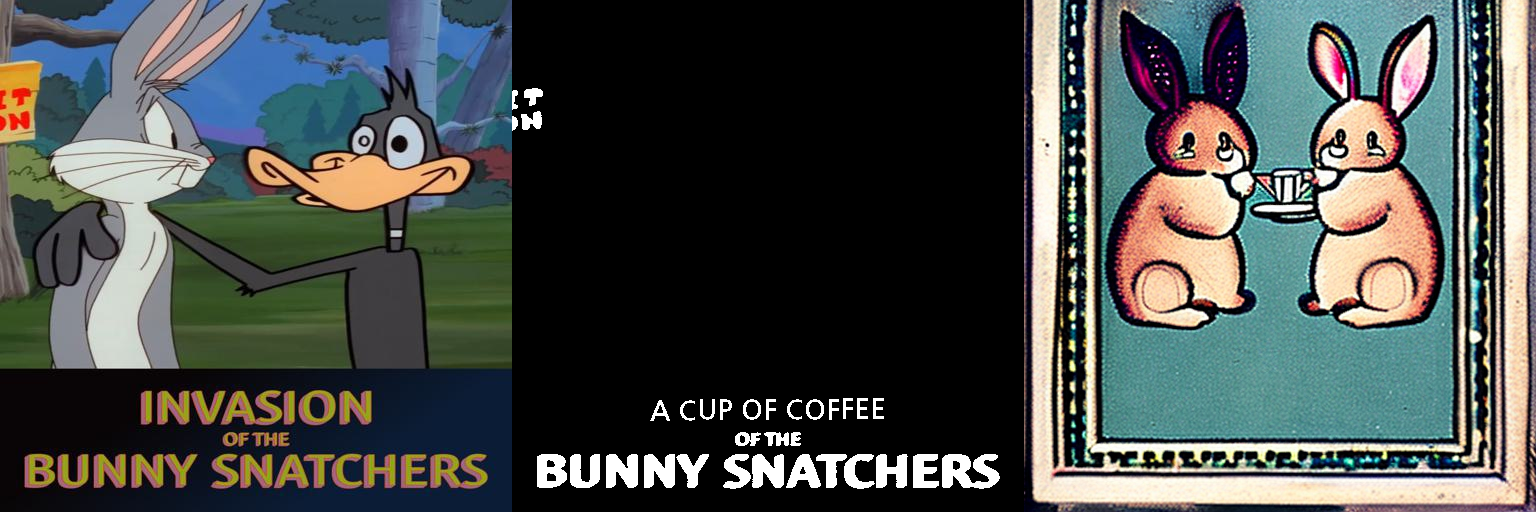

In [51]:
from diffusers import ControlNetModel, EulerAncestralDiscreteScheduler, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import make_image_grid
from PIL import ImageOps

controlnet = ControlNetModel.from_pretrained(
        "GoGiants1/GlyphControls", 
        use_safetensors=True,
        revision="textcaps5K_epoch_40_ema",
        torch_dtype=torch.float16,
        variant="fp16"
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2", 
    controlnet=controlnet, 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16",
)
controlnet_prompt = prompt + " '" +  sample_text + "'"
# controlnet_prompt = prompt
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()
inverted = ImageOps.invert(Image.fromarray(binary_tss))

control_image = inverted
output = pipe(
    prompt=controlnet_prompt,
    image=control_image,
    controlnet_conditioning_scale=1.0, 
    generator=generator,
    guidance_scale=guidance_scale,
).images[0]

out_dir = f"experiments/glyph-control/{controlnet_prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/output_cfg_{guidance_scale}.png", "PNG")
control_image.save(f"{out_dir}/control.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")

img = make_image_grid([input_image, control_image, output], rows=1, cols=3)

display(img)

In [13]:
td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    # vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
        
    ],
    torch_dtype=torch.float32
)
pipe.set_ip_adapter_scale([0.15, 0.3])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)

output = pipe(
    prompt=prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image, input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...
cuda:0
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

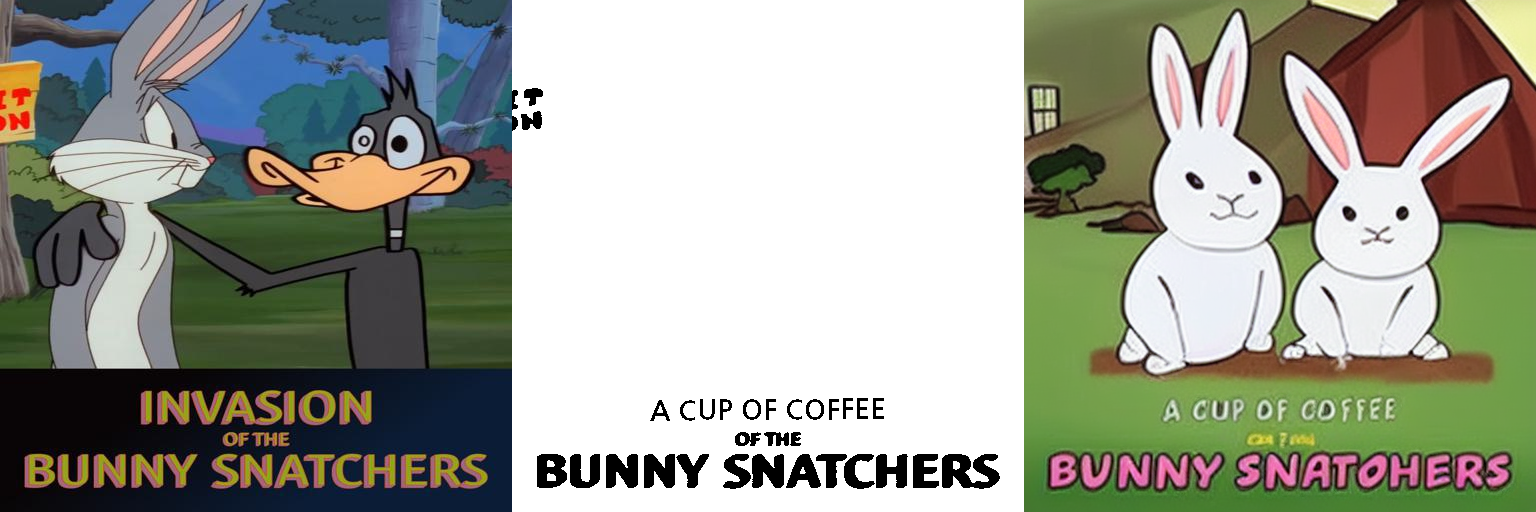

In [10]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

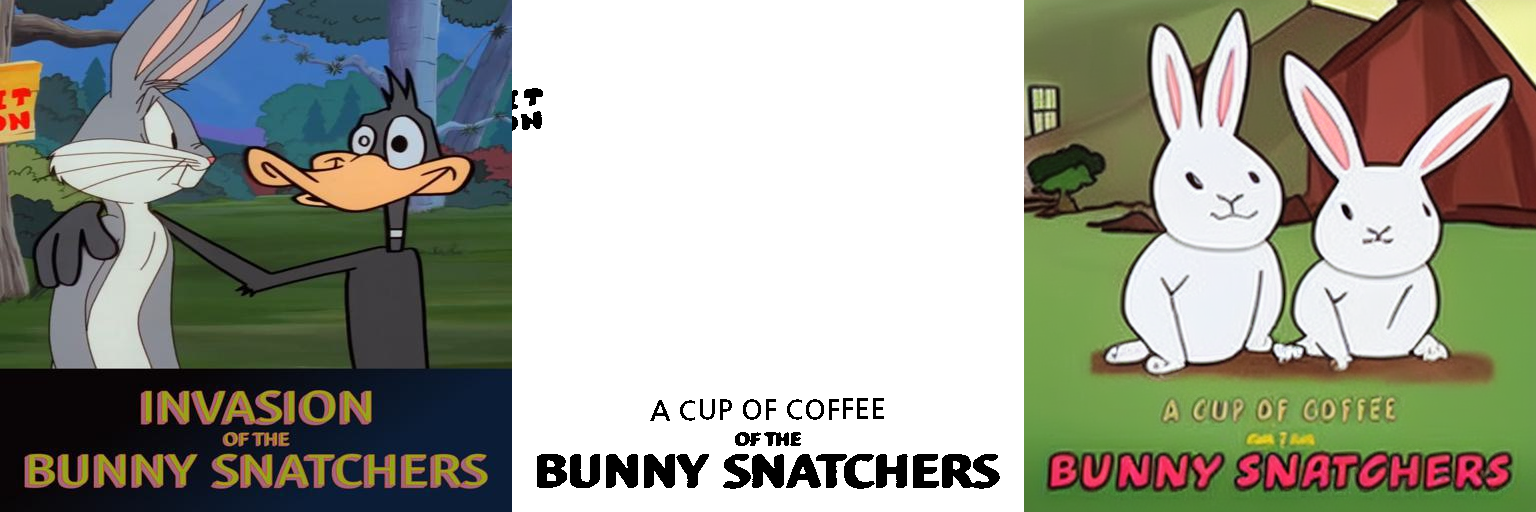

In [14]:
from diffusers.utils import make_image_grid
grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

In [42]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()
image = pipe(prompt, guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-base/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
image.save(f"{out_dir}/output.png", "PNG")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=False, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
    ],
)

scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0.7, 0.7],
    },
    "mid": [0.7],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
# block_type = "up"
# block_idx = 3
# attn_idx = 2

# if block_type == "mid":
#     scale[block_type] = 0.7
# else:
#     scale[block_type]["block_" + str(block_idx)][attn_idx]=0.7

# pipe.set_ip_adapter_scale(0.7)
pipe.set_ip_adapter_scale(scale)

pipe.enable_model_cpu_offload()

hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')

image = pipe(prompt, ip_adapter_image=[input_image], guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-ip-adapter/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_{block_type}_block{block_idx}_attn{attn_idx}.png", "PNG")
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_ip_all.png", "PNG")
image.save(f"{out_dir}/output_optimal_down_block2_mid.png", "PNG")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [44]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        name += f"_{k}_{block_name}_attn{idx}_{value}"
    
    return name

In [45]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy

# input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))
  hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')
guidance_scale = 5

""" Change the text in the original image by coordinates and  """

sample_text="MLVU Team 8"
# prompt = "a dog and a cat"
prompt = "a dog and a cat"



# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 
arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


img = out
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
gray = img
_, binary_tss = cv2.threshold(
    gray, 50, 255, cv2.THRESH_BINARY
)

_, binary_bbox = cv2.threshold(
    gray, 200, 255, cv2.THRESH_BINARY
)

binary_tss_pil = Image.fromarray(binary_tss, 'L')
binary_bbox_pil = Image.fromarray(binary_bbox, 'L')

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        
    ],
    torch_dtype=torch.float32
)

scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
blocks = ["down", "mid", "up"]
block_nums = {
    "down": range(3),
    "up": range(1, 4)
}
block_max_attn = {
    "down": 2,
    "up": 3
}


pipe.enable_model_cpu_offload()


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)

ip_scale = 0.4

out_dir = f"experiments/td-15-style-transfer/{prompt}/ip_scale{ip_scale}_new_test"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for block in blocks:
    scale_copy = copy.deepcopy(scale)
    if block == "mid":
        # scale_copy = copy.deepcopy(scale)
        scale_copy[block] = ip_scale
        pipe.set_ip_adapter_scale(scale_copy)
        output = pipe(
                    prompt=prompt,
                    input_image=input_image,
                    text_mask_image=text_mask_image,
                    ip_adapter_image=[input_image],
                    width=512,
                    height=512,
                    guidance_scale=guidance_scale,
                    generator=generator,
                    torch_dtype=torch.float32
                ).images[0]
        output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")
    else:
        for block_num in block_nums[block]:
            for attn_idx in range(block_max_attn[block]):
                # scale_copy = copy.deepcopy(scale)
                scale_copy[block]["block_" + str(block_num)][attn_idx]=ip_scale
                print(scale_copy)
                pipe.set_ip_adapter_scale(scale_copy)
            
                output = pipe(
                    prompt=prompt,
                    input_image=input_image,
                    text_mask_image=text_mask_image,
                    ip_adapter_image=[input_image],
                    width=512,
                    height=512,
                    guidance_scale=guidance_scale,
                    generator=generator,
                    torch_dtype=torch.float32
                ).images[0]
                output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")

    


    
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Mask shape:  (512, 512)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...
{'down': {'block_0': [0.4, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0.4, 0.4], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0.4, 0.4], 'block_1': [0.4, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0.4, 0.4], 'block_1': [0.4, 0.4], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0.4, 0.4], 'block_1': [0.4, 0.4], 'block_2': [0.4, 0]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0.4, 0.4], 'block_1': [0.4, 0.4], 'block_2': [0.4, 0.4]}, 'mid': [0], 'up': {'block_1': [0, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0.4, 0], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0.4, 0.4], 'block_3': [0, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0.4, 0.4], 'block_3': [0.4, 0, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0.4, 0.4], 'block_3': [0.4, 0.4, 0]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

{'down': {'block_0': [0, 0], 'block_1': [0, 0], 'block_2': [0, 0]}, 'mid': [0], 'up': {'block_1': [0.4, 0.4, 0.4], 'block_2': [0.4, 0.4, 0.4], 'block_3': [0.4, 0.4, 0.4]}}
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        block_idx = block_name.split("_")[-1]
                        name += f"_{k}_{block_idx}_attn{idx}_{value}"
    
    return name

In [141]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
        
    ],
    torch_dtype=torch.float32
)

scale_for_bg = {
    "down": { 
        "block_0": [0.2, 0.2],
        "block_1": [0.2, 0.2],
        "block_2": [0.4, 0.2],
    },
    "mid": [0.2],
    "up": {
        "block_1" : [0, 0, 0],
        "block_2" : [0, 0, 0],
        "block_3" : [0.2, 0.2, 0.2]
    }
    
}

scale_for_text = {
    "down": { 
        "block_0": [0, 0.3],
        "block_1": [0, 0.3],
        "block_2": [0, 0.3],
    },
    "mid": [0],
    "up": {
        "block_1" : [0, 0, 0],
        "block_2" : [0, 0, 0],
        "block_3" : [0, 0, 0]
    }
    
}
pipe.set_ip_adapter_scale([scale_for_bg, scale_for_text])
# pipe.set_ip_adapter_scale([scale, scale])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image,input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "background_scale": scale_for_bg,
    "text_scale": scale_for_text,
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...
cuda:0
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

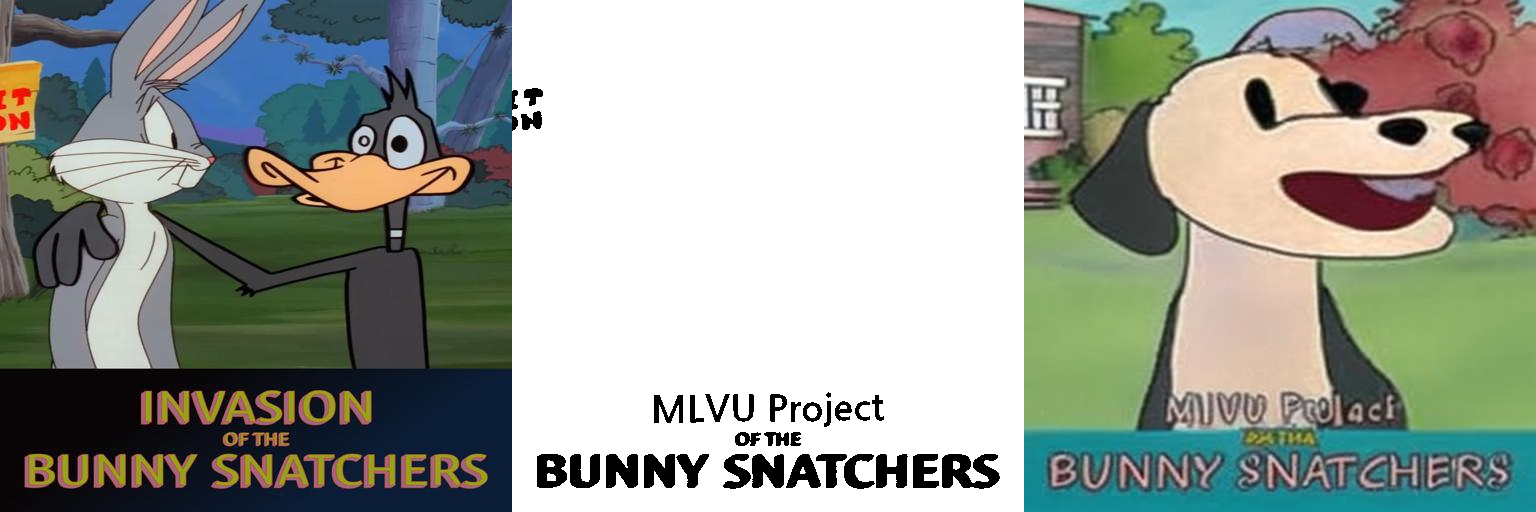

In [140]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)